
<h1>AmeriFlux and FLUXNET BIF File Parser</h1>
<p>
This notebook walks the user through reading in an AmeriFlux or FLUXNET BIF (BADM Interchange Format file) and manipulating the contents for the purposes of answering questions and/or writing out useful subsets of the data in a simple usable format. 
<p>
To start using this notebook, you will need an Excel BIF file that you downloaded from either AmeriFlux or FLUXNET. In this example, the file is in my home directory and I started with the AmeriFlux all sites BIF. This code should be able to read any BIF. 
<p>
To execute the whole notebook, choose "Cell->Run All" from the menu above. If you have updated a single segment of code in a notebook, select the cell you want to execute and choose "Cell->Run Cells". The first code cell in this notebook does all of the setup and must be run to completion before any of the other cells can be run. When it is done running, it will print 'DONE' below the code box.
<p>
In several of the code segments there are mechanisms that you can use to customize the code to do something different than it currently does. For instance, you can have it look for a different VARIABLE_GROUP or limit down the list of sites by specifying a sites filter. You can also specify whether you want to print to a file in the printtofile variable in the cells that can print to a file. 
<p>
If no path is defined in the file specification, the file is assumed to be in the same directory as this notebook.



<h2>Initialize the notebook by reading in the BIF and parsing it into useful data structures</h2>
The code block below must always be executed before trying to do any of the other activities in this notebook. Before executing, you will need to specify the name and location of the BIF file. See the first line of code in the next box to specify.
The code below completes three steps described below.
<ul>
<li><h3>Read the BIF file into a data structure</h3>
The code below first imports some useful code libraries so that they will be handy for use later. It then opens the Excel BIF file and reads it into a data structure. </li>
<li><h3>Create a class for holding the variable group</h3>
This class is an object oriented programming concept. It allows us to create a custom data type and methods for holding and operating on the variable groups in the BIF. I do not recommend modifying this class unless you are comfortable with programming in python.<\li>
<li><h3>Use the new class to turn the BIF file contents into a list of Variable Groups</h3>
This next section of the code will convert the original format of the BIF data from a Panda data frame that looked just like the BIF into a list of variable group instances with each variable group's entries included.</li>

In [21]:
# First to import useful libraries.
import numpy as np
import pandas as pd
# import to enable ordered dictionaries
# import collections as cl
import matplotlib.pyplot as plt
from operator import itemgetter
# imports to connect to and interpret web services
import requests
import json
import pprint
# import to allow us to work with files
import sys
# import to enable copying of structures
from copy import deepcopy

# open the BIF file
# customize the file name in the next line with your actual BIF file.
bif_file = pd.ExcelFile('AMF_AA-Net_BIF_LATEST.xlsx')
# bif_file = pd.ExcelFile('FLX_AA-Flx_BIF_LATEST.xlsx')
# bif_file = pd.ExcelFile('US-ARM_BIF.xlsx')

# Now read the BIF file into a data structure
bif_contents = pd.read_excel(bif_file)

# get and print the header row from the Excel file just below this code segment.
bif_header = bif_contents.columns
print("The BIF File Column Headers are:",'\n', bif_header)

# Now to check that the columns are in the order expected
correctindex = ['SITE_ID', 'GROUP_ID', 'VARIABLE_GROUP', 'VARIABLE', 'DATAVALUE']
if np.all(bif_header == correctindex): print("BIF Column order and labels in the file were as expected")
else: print("ERROR: Bad BIF file column header")
    
    
# Now to define the class structure for storing variable groups and its methods  
class VariableGrp(object):
    """" this class is to define an object that store a BADM variable group and the methods that operate on the group
         Attributes:
              param_array: Is a dictionary containing the parameters associated with this group. The first row
                            contains the label of the item and in the second row is the data value at the same index.
                            The first three columns contain the site id, the group id, and the variable group. The 
                            remaining columns contain the parameters that are in that variable group.
          Methods:
              __init__(self, header, row): This is the object constructor. It is called when a new group is first 
                          encountered to store the elements of the first row of the group. Header is the index and 
                          row is the row from the BIF file that we are interpretting.
              addparam(self, ptype, pvalue): Add the rest of the parameters to the group. Where ptype is the parameter
                          type and pvalue is parameter's value.
              getgrouptype(self): Return the type of this group (VARIABLE_GROUP)
              isgroup(self,gtype): Determine whether this is a gtype group
              hasparam(self, param, param_val): Check if this group has this parameter with the specified param_val.
              hasparamtype()
              printcontents(self): print the group in a vertical format with each parameter as a row
              printlateral(self, printlabels, labels, printtofile, fout): print out the group in column format. If Printlabels is true then it 
                              prints the column headers using the labels provided as an argument. The printtofile is a
                              boolean (True indicates that you want the output to go to the file pointed to by fout).
                              fout should be a pointer to an already open file.
              """
    def __init__(self, header, row):
            
            #create a 2D array of lists
            self.parray = dict()
            #First to store the SITE_ID, GROUP_ID, VARIABLE_GROUP
            for i in range(3):
                self.parray[header[i]] = row[i]
            #Now to add the first parameter
            # CHECK HERE IF IS EVEN THAT MANY ELEMENTS
            if len(row.index) > 4 and pd.notnull(row[4]):
                self.parray[row[3]] = row[4]          


    def addparam(self, row):
            # CHECK HERE IF IS EVEN THAT MANY ELEMENTS
            if len(row.index) > 4 and pd.notnull(row[4]):
                self.parray[row[3]] = row[4]
            return 0
    
    def getgrouptype(self):
             return self.parray["VARIABLE_GROUP"]
    
    def getsiteid(self):
            return self.parray["SITE_ID"]
        
    def getparamkeys(self):
            return self.parray.keys()
    
    def isgroup(self, gtype):
            if self.parray["VARIABLE_GROUP"] == gtype:
                    return True
            else:
                    return False
            
    def hasparam(self, param, param_val):
        try:
            if self.parray[param] == param_val: 
                return True
            else:
                return False
        except ValueError:
            return False
    
    def hasparamtype(self, param):
        try:
            if param in self.parray: 
                return True
            else:
                return False
        except ValueError:
            return False
    
    def printcontents(self):
            for param, val in self.parray.items():
                print("\t", param, val)
                
    def printlateral(self, printlabels, labels, printtofile, fout):
        columnheader = ""
        row = ""
        for param, val in labels.items():
            if(printlabels):
                columnheader = columnheader + '"' + param + '"' + ", "
            if param in self.parray:
                row = row + '"' + str(self.parray[param]) + '"' + ", "
            else:
                row = row + ", "
        if printlabels:
            print(columnheader)
            if printtofile:
                fout.write(columnheader + '\n')
        print(row)
        if printtofile:
            fout.write(row + '\n')
        
# end of definition of the class        
            
 
# Now to parse the file into instances of the Vargroup class
# first to initialize some variables
grpid = 0
grpcnt = -1
siteslist = dict()
bif_groups = dict()
# loop through the rows of the BIF file we just read in
for ndex,bif_row in bif_contents.iterrows():
    # check if this is a variable group we already started (known group_id)
    grpid = bif_row['GROUP_ID']
    #if grpid == 23931: print(gid,":",len(bif_row.index),": ", bif_row)
    if grpid in bif_groups:  
        # Add this row to the existing variable group
         bif_groups[grpid].addparam(bif_row)
    else:
        # This is a new group so we need to create a new VariableGrp and store the header and row in it
        grpcnt = grpcnt + 1
        bif_groups[grpid] = VariableGrp(bif_header, bif_row)

# Now to fill in the list of sites 
for gid, group in bif_groups.items():
    if group.getsiteid() in siteslist:
        siteslist[group.getsiteid()] += 1
    else:
        siteslist[group.getsiteid()] = 1
    params = group.getparamkeys()
    grouptype = group.getgrouptype()

# print the list of sites found in the file and the number of groups for each
# print(siteslist)
# print the last group read in just to make sure things look ok
# bif_groups[grpid].printcontents()
# print(grpcnt, " groups found ", len(siteslist.keys()), " sites found ", len(grouptypeslist.keys()), " group types found") # just to let the user know this part has executed

print('DONE  ')

The BIF File Column Headers are: 
 Index(['SITE_ID', 'GROUP_ID', 'VARIABLE_GROUP', 'VARIABLE', 'DATAVALUE'], dtype='object')
BIF Column order and labels in the file were as expected
DONE  


<h2> Find and Print all the Group Types in this File</h2>
This next code segment finds all the unique group types and prints out a list of the group types found in the file. It will also print the number of instances of the group type that were found in the file.

In [22]:
# Now to fill in the list of sites and the list of grouptypes and their parameters
grouptypeslist = dict()
for gid, group in bif_groups.items():
    params = group.getparamkeys()
    grouptype = group.getgrouptype()

    if grouptype in grouptypeslist:
        for param in params:
                if param in grouptypeslist[grouptype].keys():
                    grouptypeslist[grouptype][param] +=1
                else:                     
                    grouptypeslist[grouptype][param] = 1
    else:
        grouptypeslist[grouptype] = dict()
        for param in group.getparamkeys():
                grouptypeslist[grouptype][param] = 1

# print the group types and all parameters found for each group type
# after each parameter print the number of groups containing this parameter
for gid, grouptype in grouptypeslist.items():
    paramslist = "\n" + gid + ": " + str(grouptype["SITE_ID"]) + "(# is number of occurances)\n Parameters:"
    for param, val in grouptype.items():
        if (param != 'SITE_ID' and param != 'GROUP_ID' and param != "VARIABLE_GROUP"):
            paramslist = paramslist + param + ": " + str(val) + ", "
    print(paramslist)




GRP_ACKNOWLEDGEMENT: 71(# is number of occurances)
 Parameters:ACKNOWLEDGEMENT: 71, ACKNOWLEDGEMENT_COMMENT: 19, 

GRP_CLIM_AVG: 268(# is number of occurances)
 Parameters:MAT: 241, MAP: 240, CLIMATE_KOEPPEN: 268, REFERENCE_PAPER: 7, REFERENCE_DOI: 7, REFERENCE_USAGE: 7, 

GRP_COUNTRY: 299(# is number of occurances)
 Parameters:COUNTRY: 299, 

GRP_DOM_DIST_MGMT: 244(# is number of occurances)
 Parameters:DOM_DIST_MGMT: 244, 

GRP_FLUX_MEASUREMENTS: 611(# is number of occurances)
 Parameters:FLUX_MEASUREMENTS_METHOD: 611, FLUX_MEASUREMENTS_VARIABLE: 611, FLUX_MEASUREMENTS_DATE_START: 599, FLUX_MEASUREMENTS_OPERATIONS: 611, FLUX_MEASUREMENTS_DATE_END: 169, FLUX_MEASUREMENTS_COMMENT: 82, REFERENCE_PAPER: 7, REFERENCE_DOI: 7, REFERENCE_USAGE: 7, 

GRP_HEADER: 299(# is number of occurances)
 Parameters:SITE_NAME: 299, 

GRP_IGBP: 310(# is number of occurances)
 Parameters:IGBP: 310, IGBP_DATE_START: 55, REFERENCE_PAPER: 14, REFERENCE_DOI: 14, REFERENCE_USAGE: 14, IGBP_COMMENT: 144, 

GRP_L

<h2>Define the List of Sites to Use in Filtering the Queries in the Notebook Below Here</h2>
The code segment below defines an array with a list of sites, SitesofInterest. This list of sites will be used in many of the later code segments in the notebook to filter results. Depending on whether you want the code segments in the notebook below here to operate on all or sub-set of the sites in this BIF, uncomment (remove the # sign) on the appropriate line in the code segment right below here. Only leave one of the two lines that start with SitesofInterest uncommented.

In [23]:
SitesofInterest = []
# Customize: Uncomment only one of the three sections below (use the instructions 
# at the start of each section to learn how to comment or uncomment).

# 1. For all sites, remove the # from the front of the next line or add 
# the # to comment it out.
SitesofInterest = siteslist.keys()

# 2. To limit results to a specific list of sites, list them between 
# the brackets below and remove the # from the front of the next line
# SitesofInterest = ['US-MMS', 'US-Seg', 'CA-TPD', 'US-Ha1']

# 3. To limit results to a set of sites with a specific IGBP type, insert # 
# in the front of the two lines that start with """ below. To deactivate 
# these lines again, remove the # signs and the """
"""
SitesofInterest = []
grouptype = 'GRP_IGBP'
param = 'IGBP'
paramvalue = 'DBF'
for gid, group in bif_groups.items():
    # First to find all the GRP_IGBP groups
    if group.isgroup(grouptype):
        # Now to just look for all the IGBPs that are paramvalue
        if group.hasparam( param, paramvalue ):
            # if this is a IGBP that matches then add the site to SitesofInterest
            if group.getsiteid() not in SitesofInterest:
                SitesofInterest.append(group.getsiteid())
"""               
# Print the resulting SitesofInterest to check that it is what you want.
print('SitesofInterest contains:', SitesofInterest)            


SitesofInterest contains: dict_keys(['BR-CMT', 'BR-Ma2', 'BR-Sa1', 'BR-Sa3', 'CA-ARB', 'CA-ARF', 'CA-Ca1', 'CA-Ca2', 'CA-Ca3', 'CA-Cbo', 'CA-CF1', 'CA-CF2', 'CA-Cha', 'CA-DBB', 'CA-DL1', 'CA-DL2', 'CA-Fen', 'CA-Gro', 'CA-KLP', 'CA-Let', 'CA-LuM', 'CA-MA1', 'CA-MA2', 'CA-MA3', 'CA-Man', 'CA-Mer', 'CA-Na1', 'CA-Na2', 'CA-NS1', 'CA-NS2', 'CA-NS3', 'CA-NS4', 'CA-NS5', 'CA-NS6', 'CA-NS7', 'CA-NS8', 'CA-Oas', 'CA-Obs', 'CA-Ojp', 'CA-Qc2', 'CA-Qcu', 'CA-Qfo', 'CA-SCC', 'CA-SF1', 'CA-SF2', 'CA-SF3', 'CA-SJ1', 'CA-SJ2', 'CA-SJ3', 'CA-TP1', 'CA-TP2', 'CA-TP3', 'CA-TP4', 'CA-TPD', 'CA-WP1', 'CA-WP2', 'CA-WP3', 'CL-SDF', 'CL-SDP', 'CR-Fsc', 'CR-Lse', 'CR-Nmr', 'CR-SoC', 'MX-Lpa', 'PA-Bar', 'US-A32', 'US-A74', 'US-ADR', 'US-Akn', 'US-An1', 'US-An2', 'US-An3', 'US-AR1', 'US-AR2', 'US-ARb', 'US-ARc', 'US-ARM', 'US-Atq', 'US-Aud', 'US-Bar', 'US-BdA', 'US-BdC', 'US-Bes', 'US-Bi1', 'US-Bi2', 'US-Bkg', 'US-Blk', 'US-Blo', 'US-Bn1', 'US-Bn2', 'US-Bn3', 'US-Bo1', 'US-Bo2', 'US-Br1', 'US-Br2', 'US-Br3', 'US

 <h2>Print all the Groups that Have a Particular Parameter</h2>
 This next section of code enables you to search through all of the groups that are in the BIF file. It will filter by the sites in SitesofInterest with a particular group type and specific parameter. In this case, the example is printing out all the GRP_TEAM_MEMBERs where the TEAM_MEMBER_ROLE is equal to PI. 

In [24]:
printlabel = True
# customize this by changing the next five lines
grouptype = 'GRP_TEAM_MEMBER' # the VARIABLE_TYPE we are looking for
param = 'TEAM_MEMBER_ROLE' # the parameter to search for
paramvalue = 'PI' # the parameter value to search for
printtofile = True # set to False if you do not want a file written
filename = 'sitepis.csv' # file to write

# if we will write to a file - first open it
if printtofile:
    fout = open(filename, 'w')
# loop through all of the BIF groups in the file
for gid, group in bif_groups.items():
    # First to find all the grouptype groups (Tower team members)
    if group.isgroup(grouptype) and group.getsiteid() in SitesofInterest:
        # Now to just look for all the grouptype groups that are also for sites in our filter
        if group.hasparam( param, paramvalue ):
            # if this group is the param and paramvalue we are looking 
            # for then print out the group in a column oriented format below
            # the printlabel variable is True the first time through to print column headers
            group.printlateral(printlabel, grouptypeslist[grouptype], printtofile, fout)
            printlabel = False
# now to close the file if we opened it
if printtofile:
    fout.close()


"SITE_ID", "GROUP_ID", "VARIABLE_GROUP", "TEAM_MEMBER_NAME", "TEAM_MEMBER_ROLE", "TEAM_MEMBER_EMAIL", "TEAM_MEMBER_INSTITUTION", "TEAM_MEMBER_ADDRESS", "REFERENCE_PAPER", "REFERENCE_DOI", "REFERENCE_USAGE", 
"BR-CMT", "31061", "GRP_TEAM_MEMBER", "Mark Johnson", "PI", "mark.johnson@ubc.ca", "University of British Columbia", "2202, Main Mall, Vancouver BC V6T 1Z4, Canada", , , , 
"BR-Ma2", "22250", "GRP_TEAM_MEMBER", "Alessandro Araujo", "PI", "alessandro.araujo@gmail.com", "Embrapa Eastern Amazon", "Trav. Dr. Eneas Pinheiro, s/n, Bairro Marco, CEP: 66095-903, Caixa postal 48, Belem, PA", , , , 
"BR-Sa1", "4917", "GRP_TEAM_MEMBER", "Scott Saleska", "PI", "saleska@email.arizona.edu", "University of Arizona", "Ecology and Evolutionary Biology, 1041 E. Lowell Street,Tucson, Arizona, USA, 85721", , , , 
"BR-Sa3", "10019", "GRP_TEAM_MEMBER", "Mike Goulden", "PI", "mgoulden@uci.edu", "University of California - Irvine", "Earth System Science, 203 Physical Sciences Research Facility,Irvine, CA 

"US-CPk", "10223", "GRP_TEAM_MEMBER", "Brent Ewers", "PI", "BEEwers@uwyo.edu", "University of Wyoming", , , , , 
"US-CPk", "30324", "GRP_TEAM_MEMBER", "Elise Pendall", "PI", "e.pendall@westernsydney.edu.au", "University of Wyoming", , , , , 
"US-CPR", "33706", "GRP_TEAM_MEMBER", "Cove Sturtevant", "PI", "csturtevant@battelleecology.org", "NEON", "1685 38th Street Boulder, CO 80301", , , , 
"US-CPR", "30474", "GRP_TEAM_MEMBER", "David Durden", "PI", "ddurden@battelleecology.org", "NEON", "1685 38th Street Boulder, CO 80301", , , , 
"US-CPR", "30475", "GRP_TEAM_MEMBER", "Stefan Metzger", "PI", "neon-flux@battelleecology.org", "NEON", "1685 38th Street Boulder, CO 80301", , , , 
"US-CRT", "12784", "GRP_TEAM_MEMBER", "Jiquan Chen", "PI", "jqchen@msu.edu", "University of Toledo / Michigan State University", "202 Manly Miles Bldg. 1405 South Harrison Road Michigan State University, East Lansing, MI 48823", , , , 
"US-Cst", "13229", "GRP_TEAM_MEMBER", "Chelcy Miniat", "PI", "cfminiat@fs.fed.u

<h2>Print all the groups of the group type specified</h2>
This next section of code enables you to search through all of the groups that are in the BIF file. It will filter by the sites in SitesofInterest. It is looking for a particular group type and specific parameter. In this case, the example is printing out all the GRP_TEAM_MEMBERs where the TEAM_MEMBER_ROLE is equal to PI. This function prints all the instances of the group specified in 'grouptype'. The output will be filtered by the SitesofInterest list defined above.

In [25]:
# printlabel is used to cause the column labels to be printed out. 
printlabel = True
# customize this by changing the next 3 lines
grouptype = 'GRP_BIOMASS_CHEM'  # VARIABLE_GROUP we are looking for
printtofile = True   # Indicates whether to print to a file
filename = 'Biomasschemdata.csv'  # the file where we want to write the results

# if we will write to a file - first open it
if printtofile:
    fout = open(filename, 'w')
#loop through all of the groups that were in the BIF
for gid, group in bif_groups.items():
    # if this is a group of the group type we are looking for
    if group.isgroup(grouptype) and group.getsiteid() in SitesofInterest:
            # print this group out in column format
            group.printlateral(printlabel, grouptypeslist[grouptype], printtofile, fout)
            # turn the column labels off after the first time
            printlabel = False
            
# now to close the file if we opened it            
if printtofile:
    fout.close()

"SITE_ID", "GROUP_ID", "VARIABLE_GROUP", "BIOMASS_N", "BIOMASS_N_SPATIAL_VARIABILITY", "BIOMASS_ORGAN", "BIOMASS_PHEN", "BIOMASS_SPP", "BIOMASS_COMMENT", "BIOMASS_C", "BIOMASS_DATE", "BIOMASS_CN_RATIO", 
"BR-Ma2", "29307", "GRP_BIOMASS_CHEM", "0.15", "0.03", "Total", "Mixed/unknown", "(All)", "Non-Legumes on baixio; extracted from reference by Lucie Plourde; Nardoto, G.B. et al. 2008. Understanding the influences of spatial patterns on N availability within the Brazilian Amazon Forest. Ecosystems, 11:1234-1246. (Table 2)", , , , 
"BR-Ma2", "27181", "GRP_BIOMASS_CHEM", "0.20", "0.05", "Total", "Mixed/unknown", "(All)", "Non-Legumes on plateau; extracted from reference by Lucie Plourde; Nardoto, G.B. et al. 2008. Understanding the influences of spatial patterns on N availability within the Brazilian Amazon Forest. Ecosystems, 11:1234-1246. (Table 2)", , , , 
"BR-Ma2", "28936", "GRP_BIOMASS_CHEM", "0.23", "0.05", "Total", "Mixed/unknown", "(All)", "Legumes on plateau; extracted from refer

"CA-Let", "25616", "GRP_BIOMASS_CHEM", "0.25", , "Total", "Mixed/unknown", "(All)", "all above-ground green parts ; measured using elemental analyzer (NC2500)", "4.71", "20000515", , 
"CA-Let", "26481", "GRP_BIOMASS_CHEM", "0.22", , "Total", "Mixed/unknown", "(All)", "all above-ground green parts ; measured using elemental analyzer (NC2500)", "4.75", "20000529", , 
"CA-Let", "26124", "GRP_BIOMASS_CHEM", "0.20", , "Total", "Mixed/unknown", "(All)", "all above-ground green parts ; measured using elemental analyzer (NC2500)", "4.69", "20000612", , 
"CA-Let", "25617", "GRP_BIOMASS_CHEM", "0.18", , "Total", "Mixed/unknown", "(All)", "all above-ground green parts ; measured using elemental analyzer (NC2500)", "4.69", "20000626", , 
"CA-Let", "26614", "GRP_BIOMASS_CHEM", "0.18", , "Total", "Mixed/unknown", "(All)", "all above-ground green parts ; measured using elemental analyzer (NC2500)", "4.70", "20000711", , 
"CA-Let", "25470", "GRP_BIOMASS_CHEM", "0.19", , "Total", "Mixed/unknown", "(All

"US-Shd", "26825", "GRP_BIOMASS_CHEM", "0.13", , "Total", "Mixed/unknown", "(All)", , , "20000608", , 
"US-Shd", "25523", "GRP_BIOMASS_CHEM", , , "Total", "Mixed/unknown", "(All)", , "4.49", "20000608", , 
"US-Shd", "25264", "GRP_BIOMASS_CHEM", , , "Total", "Mixed/unknown", "(All)", , "3.93", "20000608", , 
"US-Shd", "27830", "GRP_BIOMASS_CHEM", , , "Total", "Mixed/unknown", "(All)", , "4.46", "20000608", , 
"US-Shd", "25527", "GRP_BIOMASS_CHEM", , , "Total", "Mixed/unknown", "(All)", , "3.21", "20000608", , 
"US-Shd", "26826", "GRP_BIOMASS_CHEM", "0.05", , "Total", "Mixed/unknown", "(All)", , , "20000608", , 
"US-Shd", "25524", "GRP_BIOMASS_CHEM", , , "Total", "Mixed/unknown", "(All)", , "1.81", "20000608", , 
"US-Shd", "27205", "GRP_BIOMASS_CHEM", , , "Total", "Mixed/unknown", "(All)", , "4.04", "20000608", , 
"US-Shd", "26419", "GRP_BIOMASS_CHEM", "0.07", , "Total", "Mixed/unknown", "(All)", , , "20000608", , 
"US-Shd", "26288", "GRP_BIOMASS_CHEM", "0.14", , "Total", "Mixed/unknown"

<h2>For a Particular Group Type Print the List of Sites With That Group Type</h2>
This segment of code below will loop through all of the groups in the BIF looking for the 'grouptype' matching the specified VARIABLE_GROUP and will create a list of sites with that group type and the count of how many instances of the group type each site has. The output will be filtered by the SitesofInterest list defined above.

In [26]:
# customize the line below to define the VARIABLE_GROUP desired
grouptype = "GRP_LAI" # VARIABLE_GROUP to search for
# create an empty list for holding the list of sites and the number of instances per site
sitelist = dict()
# loop through all of the groups that were in the BIF
for gid, group in bif_groups.items():
    # if this is the group type and passes the site filter
    if group.getgrouptype() == grouptype and group.getsiteid() in SitesofInterest:
        # remember the SITE_ID of this group and increment the count
        site = group.getsiteid()
        if site in sitelist:
            sitelist[site] += 1
        else:
            sitelist[site] = 1

# print below the sites reporting the group and the # of instances            
print( "List of sites reporting ", grouptype)
print("SITE_ID", "   ", "# of Instances of ", grouptype)
for site,instances in sorted(sitelist.items(), key=itemgetter(1), reverse = True):
    print( site, "\t", instances)


List of sites reporting  GRP_LAI
SITE_ID     # of Instances of  GRP_LAI
US-UMB 	 184
US-Ha1 	 131
US-Ton 	 126
US-Var 	 121
CA-Let 	 112
US-SP3 	 96
US-SP1 	 84
US-Shd 	 83
US-SP2 	 71
US-Ne1 	 69
US-Ne2 	 67
US-Ne3 	 66
US-UMd 	 66
CA-Oas 	 31
CA-Ca2 	 27
US-IB2 	 23
US-IB1 	 21
US-PFa 	 18
CA-Ojp 	 12
CA-Obs 	 8
US-Dk3 	 8
US-Me2 	 8
US-WCr 	 8
US-Ho1 	 7
US-Ho2 	 7
US-Syv 	 7
US-ARM 	 5
US-Me6 	 4
US-SRM 	 4
US-Slt 	 3
CA-Man 	 2
CA-Mer 	 2
CA-SJ3 	 2
US-Bar 	 2
US-Blo 	 2
US-Fmf 	 2
US-Fuf 	 2
US-Fwf 	 2
US-Me4 	 2
US-MOz 	 2
US-Wi3 	 2
US-Wi4 	 2
BR-Ma2 	 1
BR-Sa1 	 1
BR-Sa3 	 1
CA-Ca1 	 1
CA-Ca3 	 1
CA-Gro 	 1
CA-Na1 	 1
CA-NS1 	 1
CA-NS2 	 1
CA-NS3 	 1
CA-NS5 	 1
CA-NS6 	 1
CA-NS7 	 1
CA-Qcu 	 1
CA-Qfo 	 1
CA-SF1 	 1
CA-SF2 	 1
CA-SF3 	 1
CA-SJ1 	 1
CA-SJ2 	 1
CA-TP1 	 1
CA-TP2 	 1
CA-TP3 	 1
CA-TP4 	 1
CA-WP1 	 1
CA-WP2 	 1
CA-WP3 	 1
CR-Lse 	 1
US-ARb 	 1
US-ARc 	 1
US-Atq 	 1
US-Aud 	 1
US-Bkg 	 1
US-Bn1 	 1
US-Bn2 	 1
US-Bn3 	 1
US-Bo1 	 1
US-Brw 	 1
US-CaV 	 1
US-Dk2 	 1
US

<h2>Plot the Values of a Parameter for a Group Type and Site</h2>
This code segment plots out the values of a parameter in a group type for a specific site. It will only work for numeric parameters.

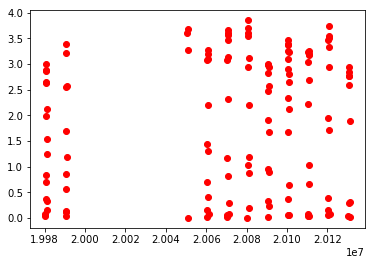

In [27]:
# customize the next four lines to define the site, group type, and parameter to plot
site = "US-Ha1"   # the site to plot values for
grouptype = "GRP_LAI"   # the VARIABLE_GROUP to plot values for
paramy = "LAI_O_DEC"  # the parameter to plot on the y axis
paramx = "LAI_DATE"   # the parameter to plot on the x axis

# First to get all the x and y values as lists for the plot
xvals = []
yvals = []
# loop through all of the groups that were in the BIF
for gid, group in bif_groups.items():
    # if this is the grouptype and and a site we are looking for
    if group.getgrouptype() == grouptype and group.getsiteid() == site:
        # if it has the parameters we are looking for paramx, paramy
        if( group.hasparamtype(paramy) and group.hasparamtype(paramx)):
            xvals.append(int(group.parray[paramx]))
            yvals.append(float(group.parray[paramy]))

# now to plot the collected values
plt.plot(xvals, yvals, 'ro')
plt.show()